#### 라이브러리 로드

In [ ]:
import os


In [8]:
import json
from pathlib import Path

from PIL import Image
import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, 'C:\\Users\\SGC\\Desktop\\efficientdet_proj\\')
import efficientdet

ModuleNotFoundError: No module named 'pycocotools'

#### 사용가능한 GPU 확인

In [142]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14430011956020081505
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8838426176
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5300975470522713133
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


훈련하고자하는 모델 선택 (D-0 ~ D-7)

In [4]:
D = 0 #@param {type: "slider", min: 0, max: 7}

In [5]:
model_config = efficientdet.config.EfficientDetCompudScaling(D=D)
im_size = model_config.input_size

print('Working with images of shape (H, W):', im_size)

Working with images of shape (H, W): (512, 512)


dataset 불러오기

In [6]:
data_path = Path('../dataset')
class_names_file = data_path / 'data_labels.names'
!cat {str(class_names_file)}
class_names_file

'cat'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


WindowsPath('../dataset/data_labels.names')

`read_class_names`로 class name 매핑

In [7]:
classes, class2idx = efficientdet.utils.io.read_class_names(class_names_file)
class2idx

{'crosswalk': 0, 'LeftTurn': 1, 'NoLeftTurn': 2, 'RightTurn': 3, 'Straight': 4}

`image.jpg`, `image.json` 모두 불러오기

In [8]:
root_data = data_path / 'train_test'
sample_images = list(root_data.glob('*.jpg'))[:3]
sample_annots = [root_data / f'{p.stem}.json' for p in sample_images]

for im_f, annot_f in zip(sample_images, sample_annots):
    print('Image:', str(im_f), '--> Annot:', str(annot_f))

Image: ..\dataset\train_test\0405170707_600.79.jpg --> Annot: ..\dataset\train_test\0405170707_600.79.json
Image: ..\dataset\train_test\0405170708_601.9017.jpg --> Annot: ..\dataset\train_test\0405170708_601.9017.json
Image: ..\dataset\train_test\0405170709_602.6265.jpg --> Annot: ..\dataset\train_test\0405170709_602.6265.json


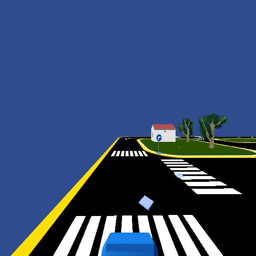

In [9]:
#이미지 확인
Image.open(sample_images[0]).resize((256, 256))

json을 로드 -> `shapes` 속성 : 사각형 pint & class 정보 포함

In [10]:
json.load(sample_annots[0].open())['shapes']

[{'label': 'crosswalk',
  'points': [[274.7029702970297, 280.0990099009901],
   [370.2475247524753, 294.4554455445545]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}},
 {'label': 'crosswalk',
  'points': [[400.94059405940595, 295.94059405940595],
   [605.8910891089108, 366.73267326732673]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}},
 {'label': 'RightTurn',
  'points': [[390.54455445544556, 251.8811881188119],
   [404.4059405940594, 264.7524752475248]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}},
 {'label': 'crosswalk',
  'points': [[129.65346534653463, 403.3762376237624],
   [559.9253617669459, 480.0]],
  'group_id': None,
  'description': '',
  'shape_type': 'rectangle',
  'flags': {}}]

In [11]:
# 데이터 셋 build
ds = efficientdet.data.labelme.build_dataset(
    annotations_path=root_data, 
    images_path=root_data, 
    class2idx=class2idx,
    im_input_size=im_size,
    shuffle=True)

image, (labels, bbs) = next(iter(ds))

print('Image shape:', image.shape)
print('Labels shape:', labels.shape)
print('Bounding boxes shape:', bbs.shape)

Image shape: (512, 512, 3)
Labels shape: (2,)
Bounding boxes shape: (2, 4)


The types and shapes are:

| element | dtype | shape |
|--------|--------|-----------
| image | tf.float32 | [HEIGHT, WIDTH, 3] |
| labels | tf.int32 | [N_ELEMS] |
| boxes | tf.float32 | [N_ELEMS, 4] |

Boxes are always formated as (x_min, y_min, x_max, y_max) and using absolute image sizes.

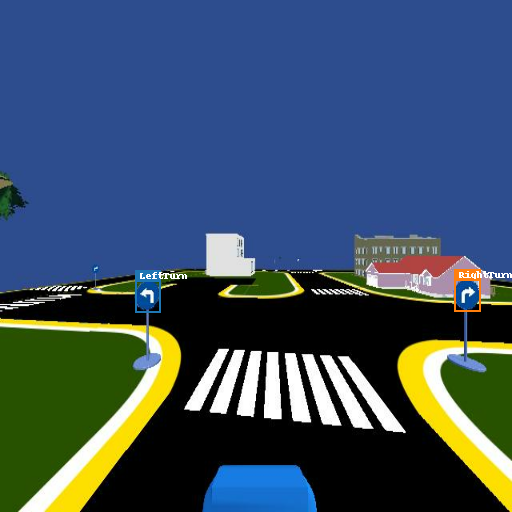

In [12]:
# image 및 label 함께 확인 시각화
image, (labels, bbs) = next(iter(ds))

image_n = efficientdet.data.preprocess.unnormalize_image(image)

labels_name = [classes[l] for l in labels.numpy().tolist()]
colors = efficientdet.visualizer.colors_per_labels(labels_name)

efficientdet.visualizer.draw_boxes(image_n, bbs, labels_name, colors=colors)

train, validation dataset 나누기

In [13]:
ds_len = sum(1 for _ in ds)

train_len = int(ds_len * .9) # 90% of validation data

train_ds = ds.take(train_len) # Take the first instances
valid_ds = ds.skip(train_len) # Skip the first instances, so the sets do not intersect

# Data augmentation on training set
train_ds = (train_ds
            .map(efficientdet.augment.RandomHorizontalFlip())
            .map(efficientdet.augment.RandomCrop()))

In [14]:
batch_size = 4 #@param {type: "slider", min: 2, max: 64}

In [15]:
padded_image_shape = (*im_size, 3)
padded_labels_shape = (None,)
boxes_padded_shape = (None, 4)

train_ds = train_ds.padded_batch(batch_size=batch_size,
                                 padded_shapes=(padded_image_shape, 
                                                (padded_labels_shape, 
                                                 boxes_padded_shape)),
                                 padding_values=(0., (-1, -1.)))

valid_ds = valid_ds.padded_batch(batch_size=batch_size,
                                 padded_shapes=(padded_image_shape, 
                                                (padded_labels_shape, 
                                                 boxes_padded_shape)),
                                 padding_values=(0., (-1, -1.)))

In [16]:
wrapped_train_ds = efficientdet.wrap_detection_dataset(
        train_ds, im_size=im_size, num_classes=len(class2idx))

wrapped_valid_ds = efficientdet.wrap_detection_dataset(
        valid_ds, im_size=im_size, num_classes=len(class2idx))

## Training

In [17]:
epochs = 70 #@param {type: "slider", min: 2, max: 120}

#@markdown Compute COCO mAP every `valdiate_freq` epochs
valdiate_freq = 10 #@param {type: "slider", min: 1, max: 10}


VOC2007 데이터 셋에서 사전 훈련된 가중치를 사용하여 EfficientDet 사용

5개 parameter 설정
- `D`: EfficientDet 모델 선택
- `num_classes`: 데이터 세트에서 사용 가능한 클래스 `len(class2idx)`.
- `training_mode`: 학습할 때 'True'로 설정합니다.

In [18]:
# model = efficientdet.EfficientDet(D=D,
#                                   num_classes=len(class2idx),
#                                   training_mode=True,
#                                   weights='D0-VOC',
#                                   custom_head_classifier=True)

In [19]:
model = efficientdet.EfficientDet(D=D,
                                  num_classes=len(class2idx),
                                  training_mode=True)

optimizer, optimizer scheduler 로드

In [20]:
# We have to calculate the steps per epoch in order to create the 
# learning rate scheduler
steps_per_epoch = sum(1 for _ in wrapped_train_ds)
lr = efficientdet.optim.WarmupCosineDecayLRScheduler(
            1e-4,
            warmup_steps=steps_per_epoch,
            decay_steps=steps_per_epoch * (epochs - 1),
            alpha=0.1)
 
# optimizer = tfa.optimizers.AdamW(learning_rate=lr, 
#                                  weight_decay=4e-5)

optimizer = tf.optimizers.Adam(
    learning_rate=lr, decay=4e-5
)

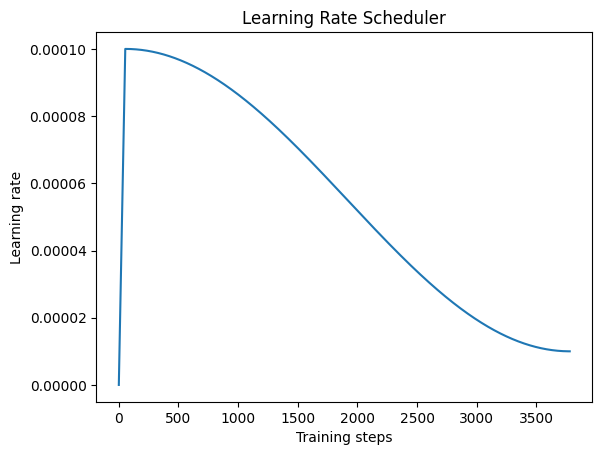

In [21]:
lrs = [lr(o) for o in range(steps_per_epoch * epochs)]

plt.plot(range(len(lrs)), lrs)
plt.xlabel('Training steps')
plt.ylabel('Learning rate')
plt.title('Learning Rate Scheduler')
plt.show();

model complie 및 model trian 

In [22]:
clf_loss = efficientdet.losses.EfficientDetFocalLoss()
reg_loss = efficientdet.losses.EfficientDetHuberLoss()

model.compile(loss=[reg_loss, clf_loss], 
              optimizer=optimizer, loss_weights=[1., 1.])

model.build([None, *im_size, 3])
model.summary()

Model: "efficient_det"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EfficientNetB0 (Functional)  [(None, None, None, 96),  4049564   
_________________________________________________________________
bi_fpn (BiFPN)               multiple                  1155705   
_________________________________________________________________
retina_net_classifier (Retin multiple                  18477     
_________________________________________________________________
retina_net_bb_predictor (Ret multiple                  17892     
Total params: 5,241,638
Trainable params: 5,192,070
Non-trainable params: 49,568
_________________________________________________________________


In [23]:
# model train
callbacks = [
    efficientdet.callbacks.COCOmAPCallback(valid_ds, 
                                           class2idx, 
                                           validate_every=valdiate_freq)
]

with tf.device("/device:GPU:0"):
    history = model.fit(wrapped_train_ds, 
            validation_data=wrapped_valid_ds, 
            epochs=epochs,
            callbacks=callbacks)

creating index...
index created!
Epoch 1/70
54/54 [==============================] - 46s 502ms/step - loss: 1.9199 - output_1_loss: 0.3114 - output_2_loss: 1.6085 - val_loss: 1.4818 - val_output_1_loss: 0.2519 - val_output_2_loss: 1.2299
Epoch 2/70
54/54 [==============================] - 29s 517ms/step - loss: 1.8924 - output_1_loss: 0.2886 - output_2_loss: 1.6038 - val_loss: 1.4825 - val_output_1_loss: 0.2520 - val_output_2_loss: 1.2304
Epoch 3/70
54/54 [==============================] - 172s 3s/step - loss: 1.8682 - output_1_loss: 0.2721 - output_2_loss: 1.5960 - val_loss: 1.4851 - val_output_1_loss: 0.2529 - val_output_2_loss: 1.2323
Epoch 4/70
54/54 [==============================] - 116s 2s/step - loss: 1.8274 - output_1_loss: 0.2459 - output_2_loss: 1.5816 - val_loss: 1.4856 - val_output_1_loss: 0.2515 - val_output_2_loss: 1.2341
Epoch 5/70
54/54 [==============================] - 102s 2s/step - loss: 1.7741 - output_1_loss: 0.2287 - output_2_loss: 1.5454 - val_loss: 1.4855 - va

`training_mode`를 `False`로 설정하고 `score_threshold`를 변경하면서 조정

In [132]:
model.training_mode = False
model.filter_detections.score_threshold = 0.2 # 0.2이상인 모든 bbox를 표현함

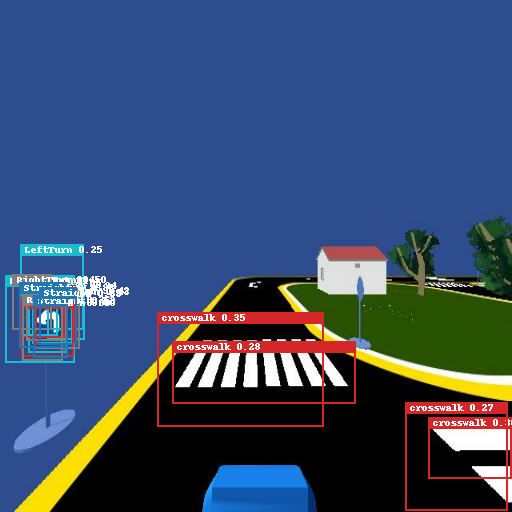

In [140]:
# random image 1장에 대한 예측 시각화 

image, _ = next(iter(valid_ds.unbatch().shuffle(20).take(1)))

bbs, labels, scores = model(tf.expand_dims(image, 0), training=False)

image_n = efficientdet.data.preprocess.unnormalize_image(image)

# Covert dataset labels to names
labels_name = [classes[l] for l in labels[0].numpy().tolist()]

# For each different name get a color
colors = efficientdet.visualizer.colors_per_labels(labels_name)

# Get a Pillow image with drew boxes, and automatically plot it
efficientdet.visualizer.draw_boxes(
    image_n, bbs[0], labels_name, scores=scores[0], colors=colors)